In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [2]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 600 files belonging to 2 classes.


In [3]:
data_iterator = data.as_numpy_iterator()

In [4]:
batch = data_iterator.next()

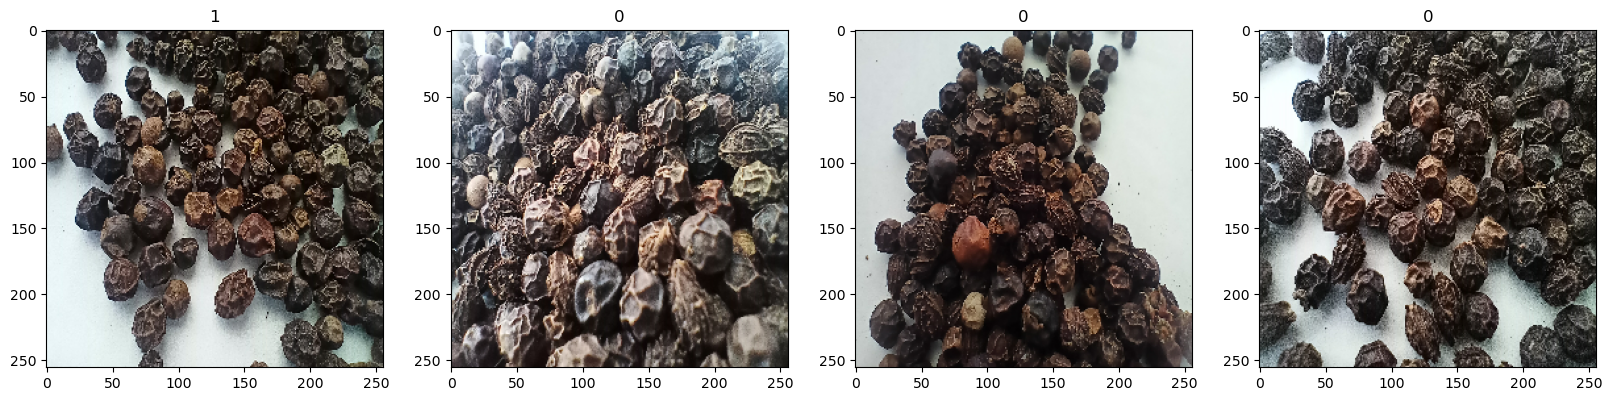

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
data = data.map(lambda x, y: (x / 255, y))
data = data.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))

In [7]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)

In [8]:
train_size

15

In [9]:
val_size

1

In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [11]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

In [12]:
train = train.map(augment_image)

In [13]:
train

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
model = Sequential()

In [15]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [18]:
logdir='logs'

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/50


15/15 [==============================] - 26s 1s/step - loss: 3.6717 - accuracy: 0.6625 - val_loss: 1.2705 - val_accuracy: 0.7812
Epoch 2/50
15/15 [==============================] - 23s 1s/step - loss: 1.3614 - accuracy: 0.7229 - val_loss: 0.7040 - val_accuracy: 0.7500
Epoch 3/50
15/15 [==============================] - 22s 1s/step - loss: 0.7693 - accuracy: 0.7375 - val_loss: 0.5467 - val_accuracy: 0.8750
Epoch 4/50
15/15 [==============================] - 23s 1s/step - loss: 0.7503 - accuracy: 0.7542 - val_loss: 0.5916 - val_accuracy: 0.8125
Epoch 5/50
15/15 [==============================] - 24s 1s/step - loss: 0.6741 - accuracy: 0.7750 - val_loss: 0.6269 - val_accuracy: 0.8438
Epoch 6/50
15/15 [==============================] - 24s 1s/step - loss: 0.6293 - accuracy: 0.8021 - val_loss: 0.6171 - val_accuracy: 0.7812
Epoch 7/50
15/15 [==============================] - 23s 1s/step - loss: 0.6144 - accuracy: 0.8208 - val_loss: 0.3429 - val_accuracy: 1.0000
Epoch 8/50
15/15 [

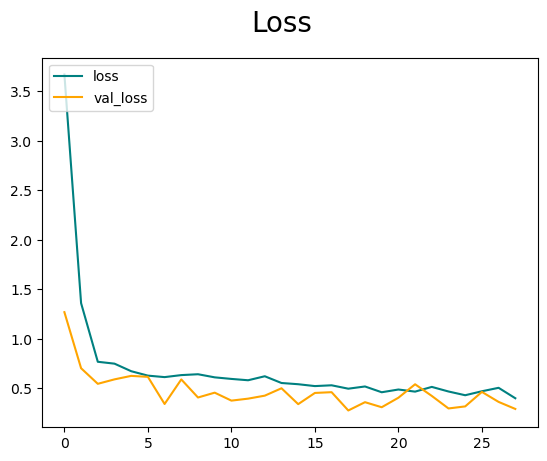

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

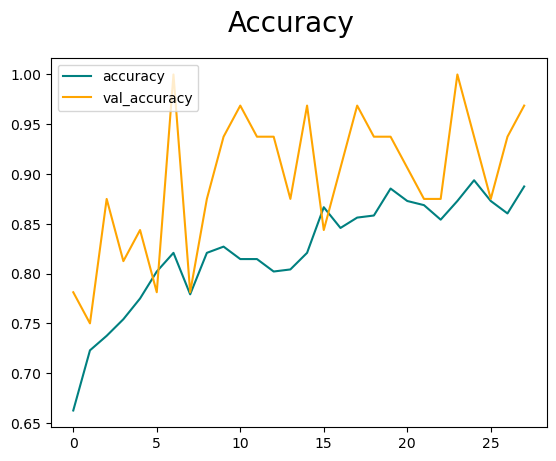

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc

In [24]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [25]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 1s/step


In [26]:
precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()
f1 = 2 * (precision * recall) / (precision + recall)

In [27]:
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Precision: 0.9166667
Recall: 0.84615386
Accuracy: 0.90625
F1 Score: 0.880000013524836


In [28]:
true_labels = []
predicted_labels = []
for batch in test:
    X, y = batch
    y_pred = model.predict(X) > 0.5 # Using 0.5 as the threshold for binary classification
    true_labels.extend(y.numpy())
    predicted_labels.extend(y_pred.astype(int))

1/1 [==============================] - 1s 546ms/step


In [29]:
report = classification_report(true_labels, predicted_labels, target_names=['Adulterated', 'Pure'], digits=4)
print(report)

              precision    recall  f1-score   support

 Adulterated     1.0000    0.9286    0.9630        14
        Pure     0.9474    1.0000    0.9730        18

    accuracy                         0.9688        32
   macro avg     0.9737    0.9643    0.9680        32
weighted avg     0.9704    0.9688    0.9686        32



In [30]:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[13  1]
 [ 0 18]]


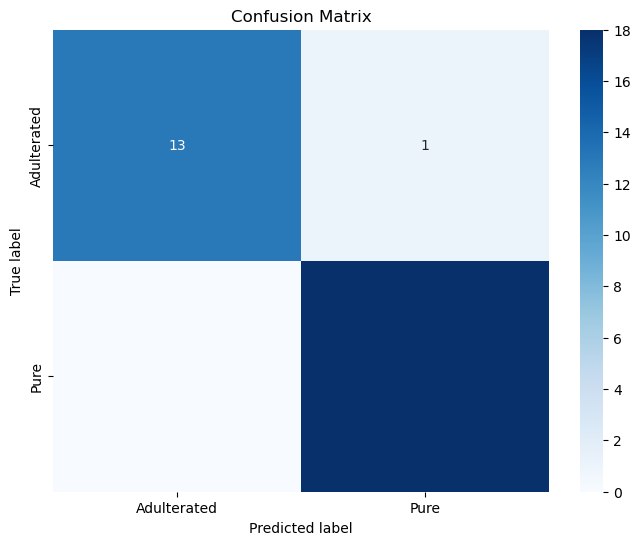

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'],
            annot_kws={"fontsize": 10, "ha": 'center', "va": 'center'})  # Center the text annotations
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Area Under Curve (AUC): 0.9736842105263157


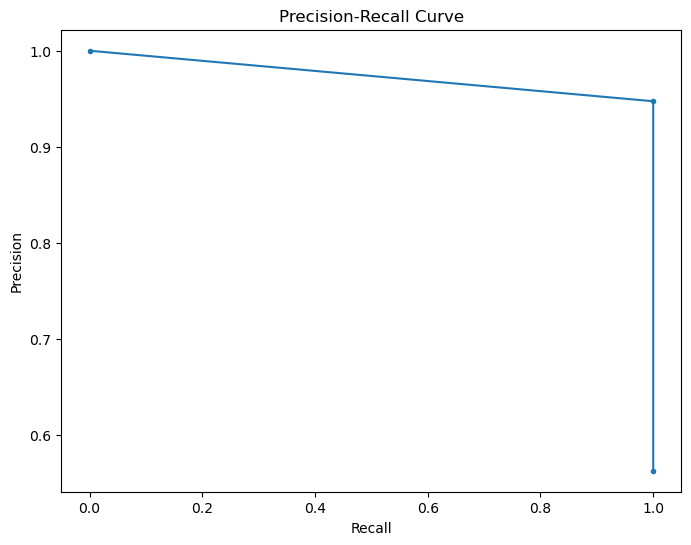

In [32]:
precision, recall, _ = precision_recall_curve(true_labels, predicted_labels)
area_under_curve = auc(recall, precision)

print("Area Under Curve (AUC):", area_under_curve)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

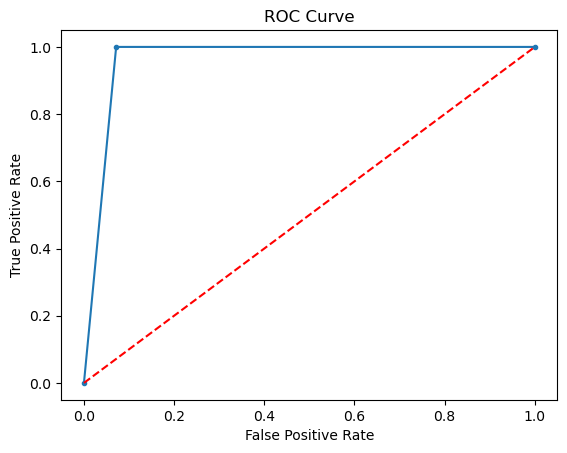

FPR: 0.0, TPR: 0.0
FPR: 0.07142857142857142, TPR: 1.0
FPR: 1.0, TPR: 1.0


In [33]:
from sklearn.metrics import roc_curve
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)

# Plot ROC curve
ax.plot(fpr, tpr, marker='.')
ax.plot([0, 1], [0, 1], linestyle='--', color='red')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

# Show the plot
plt.show()
for i in range(len(fpr)):
    print(f"FPR: {fpr[i]}, TPR: {tpr[i]}")

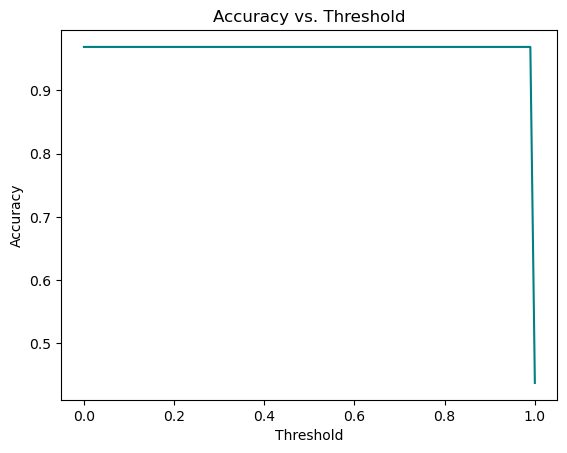

Threshold: 0.00, Accuracy: 0.9688
Threshold: 0.01, Accuracy: 0.9688
Threshold: 0.02, Accuracy: 0.9688
Threshold: 0.03, Accuracy: 0.9688
Threshold: 0.04, Accuracy: 0.9688
Threshold: 0.05, Accuracy: 0.9688
Threshold: 0.06, Accuracy: 0.9688
Threshold: 0.07, Accuracy: 0.9688
Threshold: 0.08, Accuracy: 0.9688
Threshold: 0.09, Accuracy: 0.9688
Threshold: 0.10, Accuracy: 0.9688
Threshold: 0.11, Accuracy: 0.9688
Threshold: 0.12, Accuracy: 0.9688
Threshold: 0.13, Accuracy: 0.9688
Threshold: 0.14, Accuracy: 0.9688
Threshold: 0.15, Accuracy: 0.9688
Threshold: 0.16, Accuracy: 0.9688
Threshold: 0.17, Accuracy: 0.9688
Threshold: 0.18, Accuracy: 0.9688
Threshold: 0.19, Accuracy: 0.9688
Threshold: 0.20, Accuracy: 0.9688
Threshold: 0.21, Accuracy: 0.9688
Threshold: 0.22, Accuracy: 0.9688
Threshold: 0.23, Accuracy: 0.9688
Threshold: 0.24, Accuracy: 0.9688
Threshold: 0.25, Accuracy: 0.9688
Threshold: 0.26, Accuracy: 0.9688
Threshold: 0.27, Accuracy: 0.9688
Threshold: 0.28, Accuracy: 0.9688
Threshold: 0.2

In [34]:
thresholds = np.arange(0, 1.01, 0.01)
predicted_labels = np.array(predicted_labels)
accuracies = [np.mean((predicted_labels.ravel().astype(bool) > threshold) == true_labels) for threshold in thresholds]
plt.plot(thresholds, accuracies, color='teal')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.show()
for threshold, accuracy in zip(thresholds, accuracies):
    print(f'Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}')

In [35]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [36]:
import cv2

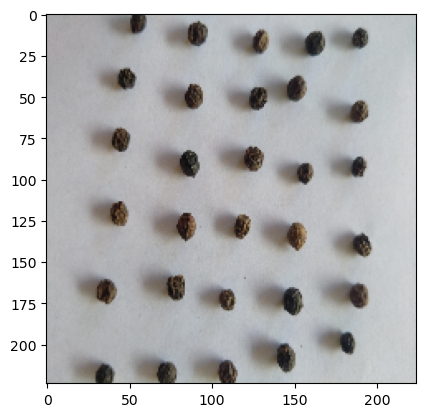

1/1 [==============================] - 0s 62ms/step
[[0.49717018]]
Predicted class is Adulterated with confidence level 0.50


In [128]:
img = cv2.imread('Test/Pure/25.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Predict the class probabilities
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

# Get the predicted class and confidence level
threshold = 0.5
predicted_class = 'Pure' if yhat[0] > threshold else 'Adulterated'
confidence_level = float(yhat[0][0]) if yhat[0] > threshold else 1 - float(yhat[0][0])
print(f'Predicted class is {predicted_class} with confidence level {confidence_level:.2f}')

In [38]:
from tensorflow.keras.models import load_model

In [39]:
model.save(os.path.join('models','mobilenet.h5'))

C:\Users\rebab\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
loaded_model = load_model('models\mobilenet.h5')

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()
with open('MobileNet.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rebab\AppData\Local\Temp\tmpiadykfkb\assets


INFO:tensorflow:Assets written to: C:\Users\rebab\AppData\Local\Temp\tmpiadykfkb\assets
